In [70]:
import cv2
import math
import glob
import inspect
import json
import mlflow
import torch
import os
import time
import sys

import lightning as L
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pytorch_lightning.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, train=True):
        self.root = root

        self.labels = dict()
        self.labels["Background"] = 0
        self.labels["Text"] = 1
        self.labels["List"] = 2
        self.labels["Picture"] = 3
        self.labels["Header"] = 4

        self.labels["Table"] = 5
        self.labels["Caption"] = 6
        self.labels["Footnote"] = 7
        self.labels["Formula"] = 8

        self.elements = []
        filenames = glob.glob(os.path.join(root, "labels/*.json"))
        for filename in filenames:
            with open(filename, "r") as f:
                data = json.load(f)
            for element in data:
                self.elements.append(element)

        n_train = int(len(self) * 0.95)

        if train:
            self.elements = self.elements[:n_train]
        else:
            self.elements = self.elements[n_train:]

    def __len__(self):
        return len(self.elements)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        element = self.elements[idx]

        filename = element["data"]["image"]
        fileparts = filename.split("/")
        filename = fileparts[-1].split("-")[0]
        img = cv2.imread(os.path.join(self.root, "images", filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255
        img = np.asarray(img, dtype=np.float32)
        h, w, c = img.shape
        label_img = np.zeros([h, w])
        
        annotations = element["annotations"][0]["result"]
        for annotation in annotations:
            original_width = annotation["original_width"]
            original_height = annotation["original_height"]
            
            percentage_x = annotation["value"]["x"]
            percentage_y = annotation["value"]["y"]
            xl = int((percentage_x * original_width) / 100)
            yl = int((percentage_y * original_height) / 100)
            
            percentage_width = annotation["value"]["width"]
            percentage_height = annotation["value"]["height"]
            width = int((percentage_width * original_width) / 100)
            height = int((percentage_height * original_height) / 100)

            xu = xl + width
            yu = yl + height
            
            label = annotation["value"]["rectanglelabels"][0]
            label_idx = self.labels[label]
            label_img[yl:yu, xl:xu] = label_idx

        N = 16
        p = 256

        nH = h // p
        nW = w // p
        H = nH * p
        W = nW * p

        img = cv2.resize(img, (1536, 2048))
        label_img = cv2.resize(label_img, (1536, 2048))
            
        patches = np.zeros([N, p, p, 3], dtype=np.float32)
        label_patches = np.zeros([N, p, p, 1], dtype=np.int64)
        pos_embeddings = np.zeros([N, p, p, 1], dtype=np.float32)
        
        coords = np.meshgrid(np.linspace(0, 1, W), 
                             np.linspace(0, 1, H))
        coords = np.asarray(coords, dtype=np.float32)
        embedding = coords[0] * coords[1]

        coords = []
        for i in range(N):
            rh = np.random.randint(0, nH - 1)
            rw = np.random.randint(0, nW - 1)
            xl = rw * p
            yl = rh * p
            xu = (rw + 1) * p
            yu = (rh + 1) * p

            coords.append((xl, xu, yl, yu))
            
            patches[i] = img[yl:yu, xl:xu]
            label_patches[i] = label_img[yl:yu, xl:xu, None]
            pos_embeddings[i] = embedding[yl:yu, xl:xu, None]

        coords = np.asarray(coords)

        img = img.transpose(2, 0, 1)
        label_img = label_img[None]
        patches = patches.transpose(0, 3, 1, 2)
        label_patches = label_patches.transpose(0, 3, 1, 2)
        pos_embeddings = pos_embeddings.transpose(0, 3, 1, 2)
        
        sample = dict()
        sample["img"] = img
        sample["label_img"] = label_img
        sample["coords"] = coords
        sample["patches"] = patches
        sample["label_patches"] = label_patches
        sample["pos_embeddings"] = pos_embeddings

        return sample

In [72]:
ROOT_PATH = "../data"
BATCH_SIZE = 4
NUM_WORKERS = 16
DEVICE = "cuda"
LR = 1e-3
N_CLASSES = 9
N_EPOCHS = 100
MODEL_IDENTIFIER = "multi-seg-documents"

In [73]:
checkpoint = None

In [74]:
train_dataset = CustomDataset(ROOT_PATH, train=True)
test_dataset = CustomDataset(ROOT_PATH, train=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=NUM_WORKERS)
print("Train:", len(train_dataset))
print("Test:", len(test_dataset))

Train: 47
Test: 3


In [75]:
element = next(iter(train_loader))

img = element["img"]
label_img = element["label_img"]
coords = element["coords"]
patches = element["patches"]
label_patches = element["label_patches"]
pos_embeddings = element["pos_embeddings"]

print("img", img.shape)
print("label_img", label_img.shape)
print("coords", coords.shape)
print("patches", patches.shape)
print("label_patches", label_patches.shape)
print("pos_embeddings", pos_embeddings.shape)

img torch.Size([4, 3, 2048, 1536])
label_img torch.Size([4, 1, 2048, 1536])
coords torch.Size([4, 16, 4])
patches torch.Size([4, 16, 3, 256, 256])
label_patches torch.Size([4, 16, 1, 256, 256])
pos_embeddings torch.Size([4, 16, 1, 256, 256])


In [76]:
counts = np.zeros(N_CLASSES)
for i, element in enumerate(train_dataset):
    print(f"\r{i + 1}|{len(train_dataset)}", end="")
    label_img = element["label_img"]
    for j in range(N_CLASSES):
        counts[j] += len(label_img[label_img == j].flatten())
print()
print()
print("counts")
print(counts)
print()
weight = 1 / torch.tensor(counts / sum(counts)).to(DEVICE).to(torch.float32)
print("weight")
print(weight)

47|47

counts
[58523686. 46254586. 16635604.  6881665.  1760292. 10016613.  4789698.
   585586.  1705725.]

weight
tensor([  2.5144,   3.1814,   8.8457,  21.3834,  83.5960,  14.6909,  30.7229,
        251.2926,  86.2703], device='cuda:0')


In [77]:
@torch.no_grad
def test_model_config():
    batch = next(iter(train_loader))
    
    img = batch["img"]
    label_img = batch["label_img"]
    coords = batch["coords"]
    patches = batch["patches"].to(DEVICE)
    label_patches = batch["label_patches"].to(DEVICE)
    pos_embeddings = batch["pos_embeddings"].to(DEVICE)

    BS, N, D, H, W = patches.shape

    print(f"input")
    print(f"  {patches.shape}")
    print(f"  {pos_embeddings.shape}")
        
    pred = model(patches, pos_embeddings)

    print(f"output")
    print(f"  {pred.shape}")
    print()
    
    pred = pred.permute(0, 1, 3, 4, 2)
    pred = pred.reshape(-1, N_CLASSES)

    label_patches = label_patches.permute(0, 1, 3, 4, 2)
    label_patches = label_patches.reshape(-1)
    
    loss = F.cross_entropy(pred, label_patches, weight=weight)
    print(loss)

In [78]:
class DecoderBlock(nn.Module):
    def __init__(self, f_in, f_mid, f_out):
        super().__init__()

        self.cnn = nn.Sequential(nn.ConvTranspose2d(f_in, f_mid, 4, 2),
                                 nn.ReLU(),
                                 nn.Conv2d(f_mid, f_mid, 3, 1, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(f_mid, f_out, 3, 1, padding=0),
                                 nn.ReLU())

    def forward(self, x):
        x = self.cnn(x)
        return x
class Decoder(nn.Module):
    def __init__(self, f_in, n_layers):
        super().__init__()

        self.n_layers = n_layers
        self.blocks = nn.ModuleList([DecoderBlock(f_in, f_in * 2, f_in) for _ in range(n_layers)])

    def forward(self, xs):
        x = xs[0]
        x = self.blocks[0](x)
        for i in range(1, self.n_layers):
            x = self.blocks[i](x + xs[i])
        return x
class EncoderBlock(nn.Module):
    def __init__(self, f_in, f_mid, f_out):
        super().__init__()

        self.cnn = nn.Sequential(nn.Conv2d(f_in, f_mid, 3, 1, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(f_mid, f_out, 3, 1, padding=1),
                                 nn.AvgPool2d((2, 2)),
                                 nn.ReLU())

    def forward(self, x):
        x = self.cnn(x)
        return x
class Encoder(nn.Module):
    def __init__(self, f_in, n_layers):
        super().__init__()

        self.blocks = nn.ModuleList([EncoderBlock(f_in, f_in * 2, f_in) for _ in range(n_layers)])

    def forward(self, x):
        xs = []
        for block in self.blocks:
            x = block(x)
            xs.append(x)
        return xs
class Model(L.LightningModule):
    def __init__(self, f=64, n_patches=16, n_classes=9, n_layers=4):
        super().__init__()

        self.automatic_optimization = False

        self.encoder = Encoder(f, n_layers)
        self.decoder = Decoder(f, n_layers)
        self.out = nn.Conv2d(f, n_patches * n_classes, 3, 1, padding=1)

    def forward(self, x, pos_emb):

        x = torch.cat([x, pos_emb], dim=2)
        BS, N, D, H, W = x.shape
        x = x.view(BS, N * D, H, W)
        xs = self.encoder(x)
        xs = [x, *xs][::-1]
        x = self.decoder(xs)
        x = self.out(x)
        x = x.view(BS, N, -1, H, W)

        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR)
        return optimizer

    def training_step(self, batch, batch_idx):

        patches = batch["patches"]
        label_patches = batch["label_patches"]
        pos_embeddings = batch["pos_embeddings"]

        optimizer = self.configure_optimizers()

        pred = self(patches, pos_embeddings)

        pred = pred.permute(0, 1, 3, 4, 2)
        pred = pred.reshape(-1, N_CLASSES)
    
        label_patches = label_patches.permute(0, 1, 3, 4, 2)
        label_patches = label_patches.reshape(-1)
        
        loss = F.cross_entropy(pred, label_patches, weight=weight)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def on_train_epoch_end(self):
        print()

    def test_step(self, batch, batch_idx):

        patches = batch["patches"]
        label_patches = batch["label_patches"]
        pos_embeddings = batch["pos_embeddings"]

        optimizer = self.configure_optimizers()

        pred = self(patches, pos_embeddings)

        pred = pred.permute(0, 1, 3, 4, 2)
        pred = pred.reshape(-1, N_CLASSES)
    
        label_patches = label_patches.permute(0, 1, 3, 4, 2)
        label_patches = label_patches.reshape(-1)
        
        loss = F.cross_entropy(pred, label_patches, weight=weight)
        
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def val_step(self, batch, batch_idx):

        patches = batch["patches"]
        label_patches = batch["label_patches"]
        pos_embeddings = batch["pos_embeddings"]

        optimizer = self.configure_optimizers()

        pred = self(patches, pos_embeddings)

        pred = pred.permute(0, 1, 3, 4, 2)
        pred = pred.reshape(-1, N_CLASSES)
    
        label_patches = label_patches.permute(0, 1, 3, 4, 2)
        label_patches = label_patches.reshape(-1)
        
        loss = F.cross_entropy(pred, label_patches, weight=weight)
        
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

In [79]:
model = Model().to(DEVICE)

test_model_config()

mlflow_logger = MLFlowLogger(
    experiment_name="default",
    tracking_uri="http://localhost:8888"
)

trainer = L.Trainer(devices=1, 
                    accelerator="gpu",
                    max_epochs=N_EPOCHS,
                    enable_checkpointing=True,
                    benchmark=True,
                    logger=mlflow_logger)

trainer.fit(model=model, 
            train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 590 K 
1 | decoder | Decoder | 1.4 M 
2 | out     | Conv2d  | 83.1 K
------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.336     Total estimated model params size (MB)


input
  torch.Size([4, 16, 3, 256, 256])
  torch.Size([4, 16, 1, 256, 256])
output
  torch.Size([4, 16, 9, 256, 256])

tensor(2.1997, device='cuda:0')


/home/henning/repos/ai-playground/projects/label_pdf_documents/venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 40:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 11/12 [00:06<00:00,  1.59it/s, v_num=436c, train_loss=2.200]

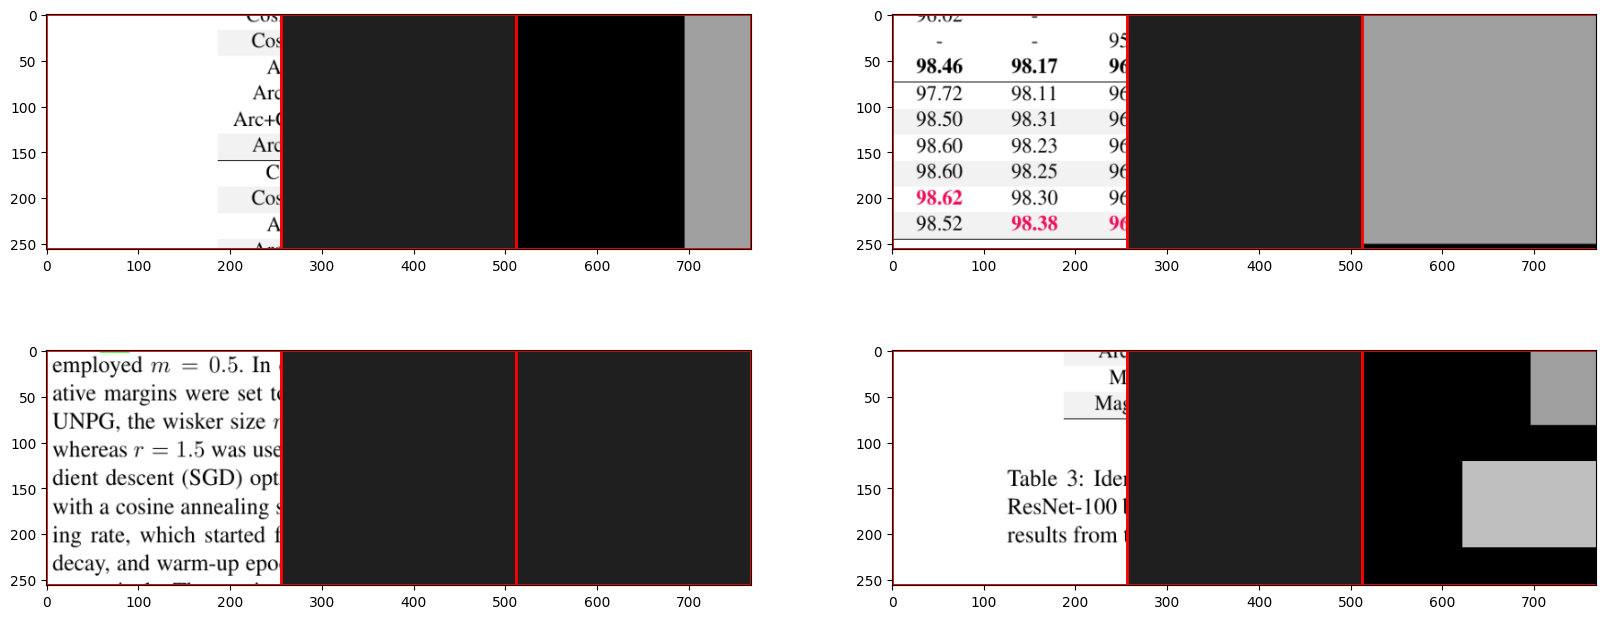

In [80]:
with torch.no_grad():
    model = model.to(DEVICE)
    batch = next(iter(train_loader))
    
    img = batch["img"]
    label_img = batch["label_img"]
    coords = batch["coords"]
    patches = batch["patches"].to(DEVICE)
    label_patches = batch["label_patches"].to(DEVICE)
    pos_embeddings = batch["pos_embeddings"].to(DEVICE)

    BS, N, D, H, W = patches.shape

    pred = model(patches, pos_embeddings)

    label_patches = label_patches.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy().argmax(axis=2)
    patches = patches.detach().cpu().numpy().transpose(0, 1, 3, 4, 2)

    width = 2
    n = 2
    m = 2
    for i in range(1):
        fig, axes = plt.subplots(n, m, figsize=(20, 8))
        for ii in range(n):
            for jj in range(m):
                idx = (ii * m) + jj

                patches_ = patches[i, idx]
                patches_ = cv2.rectangle(patches_.copy(), (0, 0), (256, 256), (1.0, 0, 0), width)
                
                gt_ = np.repeat(label_patches[i, idx, 0][:, :, None], 3, -1) / 8
                gt_ = cv2.rectangle(gt_.copy(), (0, 0), (256, 256), (1.0, 0, 0), width)
                
                pred_ = np.repeat(pred[i, idx][:, :, None], 3, -1) / 8
                pred_ = cv2.rectangle(pred_.copy(), (0, 0), (256, 256), (1.0, 0, 0), width)
                
                img_ = np.concatenate([patches_, pred_, gt_], axis=1)
                
                axes[ii, jj].imshow(img_)
        plt.show()